# Analyse von Arxiv: Strukturierte und unstrukturierte Daten

Dieses Jupyter Notebook stellt die Prüfungsaufgabe des Moduls "Maschinelles Lernen" (ROB60) der Akad University dar.

## Einführung

Die Aufgabenstellung dieser Prüfung ist es Artikel zu einem selbstgewählten Thema der Webseite [Arxiv](https://arxiv.org/) zu analysieren.
Im ersten Schritt wird ein Histogramm der über die Anzahl der Artikel pro Autor erstellt. Im Weiteren wird eine deskriptive Analyse für die verschiedenen Jahr durchgeführt.
Das Ziel ist zu eruieren, ob sich über die Jahre gewisse Parameter oder Korrelationen verändert haben. Dies könnte beispielsweise die Anzahl der veröffentlichten Artikel pro Autor
oder die Anzahl an Autoren sein. Darüber hinaus wird eine Textanalyse durchgeführt. Diese Analyse wird anhand des Abstracts der Artikel durchgeführt.
Diese Aufgaben werden sich am CRISP DM Standard orientieren und die folgenden Punkte beinhalten:

1. Verstehen der Daten (Data Understanding)
2. Datenvorbereitung (Data Preparation)
3. Modellierung (Modeling)
4. Auswertung (Evaluation)

## Extraktion und Verstehen der Daten (Data Understanding)

Für die Extraktion der Daten findet mittels der Web-API der Platform von Arxiv statt. Es wird das exemplarische Stichwort "Deep Reinforcement Learning" gewählt.
Um eine möglichst aussagekräftige Analyse durchführen zu können, werden Artikel für die Jahre 2017-2021 heruntergeladen. Pro Jahr sollen 200 Artikel heruntergeladen und in die
Analyse miteinbezogen werden.

### Beschreibung der Datenquelle und des Codes zur Extraktion

Die Platform Arxiv bietet eine Web-Api an, um Metadaten der Artikel zu extrahieren. Hierbei wird eine Anfrage an den Server mittels des Protokolls gesendet.
Die Parametrisierung findet mittels der URL statt. Für die Extraktion eben jener Daten wird das Paket `arxiv` verwendet. Es bietet eine API zur Parametrisierung der Anfrage an.
Im folgenden Code wird zunächst ein leeres Array für die extrahierten Artikel angelegt. Darüber hinaus werden die Jahreszahlen in einem Array definiert und die maximale Anzahl an Artikeln
pro Jahr. Aufgrund einer Limitation der Api, die nur maximal 200 Artikel pro Anfrage zurückliefert, werden mehrere Iterationen durchgeführt. Für jedes Jahr wird eine Suche durchgeführt und
die Metadaten Titel, Autoren, Zusammenfassung und Veröffentlichungsdatum der einzelnen Artikel einem Array hinzugefügt. Zuletzt werden die Artikel in einem Dataframe gespeichert.


In [ ]:
import arxiv
import pandas as pd
from arxiv import Search

# Variables
articles = []
years = [2018, 2019, 2020, 2021]
number_of_articles = 200
client = arxiv.Client()

for year in years:

    # Define search query
    search_query = f"Deep Reinforcement Learning AND submittedDate:[{year}01010000 TO {year}12312359]"

    # Search for the articles
    search = Search(
        query=search_query,
        max_results=number_of_articles,
    )

    # Request the articles
    results = client.results(search)

    # Save retrieved data in array
    for result in results:
        article = {
            "Title": result.title,
            "Authors": [str(author) for author in result.authors],
            "Abstract": result.summary,
            "PublishedDate": result.published.date(),
        }
        articles.append(article)

# Save articles in data frame
df = pd.DataFrame(articles)

# Print types and head
print(f"Types of the data frame \n {df.dtypes}")
print(f"The head of the data frame \n {df.head()}")

## Vorbereiten der Daten (Data Preparation)

Im folgenden Abschnitt wird eine Aufbereitung der Daten vorgenommen. Dies ist ein essenzieller Teil jedes Datenprojektes. Je besser die Daten aufbereitet wurden, desto aussagekräftiger
sind die Ergebnisse der nachfolgenden Analyse des Datenbestands. Sie wird unmittelbar nach der Extraktion der Daten vorgenommen. Hierzu gehören üblicherweise folgende Schritte:

1. Umbenennung der Spalten für eine aussagekräftigere Darstellung der Daten und des verarbeitenden Codes.
2. Entfernung irrelevanter Spalten für die weitere Verarbeitung
3. Entfernung von Duplikaten und Zeilen mit Null-Werten.
4. Entfernung von Ausreißern

Aus der Codezelle zur Datenextraktion geht hervor, dass eine Selektion und Benennung der Spalten für das DataFrame bereits stattgefunden hat. Die ersten beiden Schritte wurden somit durchgeführt.
Eine Bereinigung von Ausreißern findet in diesem DataFrame nicht statt, da außer dem Veröffentlichungsdatum keine numerischen Werte enthalten sind. Eine Bereinigung von Ausreißern wäre hier auch nicht nötig,
da die Jahreszahlen explizit bei der Abfrage parametrisiert wurden.

In der folgenden Codezelle wird nach der Extraktion eine Bereinigung der Werte hinsichtlich vorkommender Null-Werte vorgenommen. Hierzu wird die Methode `dropna` auf das DataFrame angewendet.
Zudem wird die Spalte `Authors` expandiert. Viele Artikel haben mehrere Autoren. Diese wurden im DataFrame als `list` gespeichert. Damit die Analyse hinsichtlich der Anzahl veröffentlichter Publikationen pro Autor durchgeführt werden kann,
ist es sinnvoll mit der Methode `explode` eine Expansion durchzuführen. Diese Operation wird nachfolgend exemplarisch dargestellt.

Ausgehend von der folgenden Tabelle in denen exemplarisch zwei Publikationen von mehreren Autoren verfasst wurden, sollen für jeden Autor weitere Datensätze erzeugt werden.
Die anderen Werte sollen dabei nicht verändert werden

| Titel   | Autoren            | Veröffentlichungsdatum |
|---------|--------------------|------------------------|
| Titel A | [Autor A, Autor B] | 2018                   |
| Titel B | [Autor B, Autor C] | 2019                   |

Das Ergebnis der Methode `explode` würde wie folgt aussehen:

| Titel   | Autoren | Veröffentlichungsdatum |
|---------|---------|------------------------|
| Titel A | Autor A | 2018                   |
| Titel A | Autor B | 2018                   |
| Titel B | Autor B | 2019                   |
| Titel B | Autor C | 2019                   |

Mithilfe der zweiten Tabelle kann nun eine Quantifizierung der Autoren pro Publikation durchgeführt werden.
Hierzu wird über die definierten Jahre iteriert und das DataFrame für das entsprechende Jahr gefiltert. Dies wird mit der `isin`-Methode getan.
Die zehn Autoren mit den meisten geschrieben Publikationen des entsprechenden Jahres werden auf der Spalte mit der Methode `value_counts` erhoben.
Eine Limitierung auf die 10 Autoren mit den meisten Publikation wird mit der Methode `head` durchgeführt.
Anschließend wird das Histogramm dargestellt. Die Autoren werden auf der x-Achse dargestellt. Für jeden Autor gibt es einen Balken.
Auf der y-Achse erweist sich eine Skala von 0 bis 10 als sinnvoll. Die Schrittweite beträgt 1.

In [ ]:
import matplotlib.pyplot as plt
from extraction import extract_data_from_arxiv
import pandas as pd

# Extract data from API
df = extract_data_from_arxiv()

# Ensure PublishedDate is in datetime format
df["PublishedDate"] = pd.to_datetime(df["PublishedDate"], errors="coerce")

# Drop rows with null values in Authors or PublishedDate
df = df.dropna(subset=["Authors", "PublishedDate"])

# Expand the possible multiple authors of a paper to an own entry for each author
df = df.explode(column="Authors")

# Define the years to analyze
years = range(2018, 2022)

for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Skip the year if no data is found
    if year_filtered_df.empty:
        print(f"No data found for year {year}. Skipping.")
        continue

    # Count authors for the selected year and take the top 10 authors with the most publications
    top_author_counts = year_filtered_df["Authors"].value_counts().head(10)

    # Plot the histogram
    top_author_counts.plot(kind="bar")
    plt.title(f"Top 10 authors for {year}")
    plt.xlabel("Author")
    plt.ylabel("Count")
    plt.yticks(range(0, max(top_author_counts.max() + 1, 11), 1))
    plt.show()

## Darstellung der Artikel pro Monat in einem Histogramm

Nach der Vorbereitung der Daten geht es weiter mit der explorativen Analyse basierend auf den extrahierten und präparierten Daten. Basierend auf dem CRISP-DM Standard, ist die explorative Analyse dem vierten Schritt "Modeling" zuzuordnen.
Ziel dieses Schrittes eine statistische Methode für die Gewinnung von Informationen aus den Daten auszuwählen. In Verbindung mit dem ersten Schritt "Business Understanding" des Standards CRISP-DM erfolgt eine Bewertung des definierten Testmodells gegenüber den definierten analytischen Ziele des Data-Mining-Projekts. Der Schritt "Business Understanding" wird in dieser Ausarbeitung keine besondere Rolle spielen. Es sei der Vollständigkeit halber jedoch erwähnt.

Ziel der folgenden explorativen Analyse ist die Darstellung der Anzahl der veröffentlichten Artikel pro Monat für die Jahre 2018-2022. Ziel dieser Analyse ist Gewinnung der Information, ob in einem bestimmten Zeitraum Häufungen für die Veröffentlichung auftreten und wenn ja, ob diese wiederkehrend von Jahr zu Jahr auftreten. Als analytische Methode wurde hierfür ein Histogramm gewählt. Das Balkendiagramm zeigt auf der x-Achse die Monate Januar-Dezember an und auf der y-Achse die Anzahl der veröffentlichten Artikel.

Für die Darstellung der Monate wird das Paket `calendar` verwendet. Die Sequence `month_name` wird iteriert und ihre Namen gemäß der bekannten Reihenfolge der Monate geordnet. Anschließend wird für jedes Jahr die Einträge des DataFrame zum entsprechenden Jahr in einem DataFrame namens `year_filtered_df` gespeichert. Sollten keine Daten für das jeweilige Jahr vorhanden sein, wird die aktuelle Iteration übersprungen. Sind Daten vorhanden, wird das DataFrame basierend auf der Spalte `PublishedDate` gruppiert. Dies geschieht mit der zuvor erwähnten Sequence `month_name`. Die gruppierten Einträge werden gezählt und mit der Methode `reindex` werden die gezählten Einträge den Monaten zugeordnet. Aus dieser Operation resultiert die Liste `articles_per_month`. Anschließend werden die Daten visualisiert.

In [ ]:
import matplotlib.pyplot as plt
from calendar import month_name
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define years and the months order
years = range(2018, 2022)

# Get a mapping of month names to their numerical values
month_order = {month: i for i, month in enumerate(month_name) if month}

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=True)

for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Skip the year if no data is found
    if year_filtered_df.empty:
        print(f"No data found for year {year}. Skipping.")
        continue

    # Get number of articles per month and sort the series by the index
    articles_per_month = (year_filtered_df["PublishedDate"].groupby(year_filtered_df["PublishedDate"].dt.month_name())
                          .count()
                          .reindex(month_order, fill_value=0))

    # Plot the histogram
    articles_per_month.plot(kind="bar")
    plt.title(f"Number of articles per month for {year}")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.yticks(range(0, max(articles_per_month.max() + 1, 11), 10))
    plt.show()

## Darstellung der Anzahl der Autoren pro Monat in einem Histogramm

Als weitere Analyse im Rahmen des Schritts "Modeling" des Standards CRISP-DM, wird untersucht, wie viele Autoren pro Monat Artikel veröffentlicht haben. Als statistische Analyse wird ebenfalls ein Histogramm in Erwägung gezogen, da diese Methode die Relation zwischen der Anzahl der Autoren und den Monaten am besten darstellt. Ähnlich zu vorherigen Zelle wird auch hier das Paket `calendar` für die Zuordnung der Daten zu den Monaten genutzt. Nach der Filterung der Daten nach dem zu analysierenden Jahr wird eine Gruppierung nach den Monaten durchgeführt. Im Weiteren wird auf die Spalte "Authors" zugegriffen und die Elemente gezählt. Die Methode `nunique` zählt dabei eineindeutigen Elemente, sodass die Autoren nicht mehrmals gezählt werden. Dies würde das Ergebnis in jeder Hinsicht verfälschen. In Bezug auf diese Analyse kann `nunique` als Umkehroperation zur `explode`-Methode aus dem Kapitel "Data Preparation" verstanden werden. Die Methode `reindex` ordnet die resultierende Anzahl der Autoren den Monaten. Zum Schluss werden die Histogramme für jedes Jahr ausgegeben.

In [ ]:
import matplotlib.pyplot as plt
from calendar import month_name
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define years and the months order
years = range(2018, 2022)

# Get a mapping of month names to their numerical values
month_order = {month: i for i, month in enumerate(month_name) if month}

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=True)

for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Skip the year if no data is found
    if year_filtered_df.empty:
        print(f"No data found for year {year}. Skipping.")
        continue

    # Get number of authors per month and sort the series by the index
    authors_per_month = (year_filtered_df.groupby(year_filtered_df["PublishedDate"].dt.month_name())["Authors"]
                         .nunique()
                         .reindex(month_order, fill_value=0))

    # Plot the histogram
    authors_per_month.plot(kind="bar")
    plt.title(f"Number of authors per month for {year}")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.yticks(range(0, max(authors_per_month.max() + 1, 11), 10))
    plt.show()

## Analyse der Keywords des Titels in einer Wordcloud

In [ ]:
import pandas as pd
import re as regex
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define the relevant years for the analysis
years = range(2018, 2022)

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=True)


# Clean the titles from special chars and lower the text
def clean_text(text):
    text = text.lower()
    text = regex.sub(r'\[.*?\]', '', text)
    text = regex.sub(r'[%s]' % regex.escape(string.punctuation), '', text)
    text = regex.sub(r'\w*\d\w*', '', text)
    return text


for year in years:

    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Clean the title from special characters
    cleaned_df = pd.DataFrame(year_filtered_df["Title"].apply(clean_text))

    # Set the stop words
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
        background_color="white",
        stopwords=stopwords,
        max_words=500,
        max_font_size=100,
        random_state=100,
    ).generate(str(cleaned_df))

    # Print the wordcloud
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

    # Identify topics in the titles of the articles using the Latent Dirichlet allocation
    vectorizer = CountVectorizer(
        min_df=2,
        max_df=0.95,
        max_features=1000,
        stop_words='english',
    )
    transformed_vectorizer = vectorizer.fit_transform(cleaned_df["Title"])
    feature_names = vectorizer.get_feature_names_out()

    # Tries to create combinations from the titles regarding multiple topics. The hyperparameters are the number of components,
    # the maximum iterations and the learning method
    lda = LatentDirichletAllocation(
        n_components=20,
        max_iter=5,
        learning_method='online',
        learning_offset=50,
        random_state=0,
    ).fit(transformed_vectorizer)

    # Print topics
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Thema: {topic_idx}")
        print([feature_names[i] for i in topic.argsort()[:-5 - 1:-1]])

## Darstellung der Länge des Abstracts in einem Boxplot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from extraction import extract_data_from_arxiv
from preparation import prepare_data

# Define the years to analyze
years = range(2018, 2022)

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=True)


# Define a function that removes the spaces from the abstract and calculates the length
def calculate_trimmed_length(text: str):
    return len(text.replace(" ", ""))


# Sort the dataframe by the values
df = df.sort_values(by=["PublishedDate"])

# Calculate the length of the abstract
df["abstract_length"] = df["Abstract"].apply(calculate_trimmed_length)

# Print boxplot
plt.figure(figsize=(6, 4))
sns.boxenplot(y=df["abstract_length"], color="skyblue")
plt.ylabel("Länge des Abstracts in Anzahl Zeichen")
plt.title("Boxplot der Abstract-Längen")
plt.show()

## Häufigkeitsanalyse von Themen der Abstracts für jedes Jahr

In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.cli import download
from extraction import extract_data_from_arxiv
from preparation import prepare_data
from collections import Counter

# Define the years to analyze
years = range(2018, 2022)

# Extract and prepare data
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=False)

# Download and load the language model for the stopwords removal and the lemmatization
download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")


# Define a function to be applied on the Abstract column for the text preparation
def clean_text(text):
    doc = nlp(text)
    filtered_words = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(filtered_words)


# Apply the text preparation on the abstract column
df["Abstract"] = df["Abstract"].apply(clean_text)

# Iterate over years and create a bar chart for every year
for year in years:
    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year]

    # Collect all words from the abstracts
    all_words = " ".join(year_filtered_df["Abstract"]).split()

    # Calculate the word frequency for every word and take the 10 most common words
    word_frequency = Counter(all_words)
    top_words = word_frequency.most_common(10)

    # Create a dataframe from the words and the frequencies
    word_df = pd.DataFrame(top_words, columns=["Word", "Frequency"])

    # Print the bar chart
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Frequency", y="Word", data=word_df)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title(f"Top 10 most frequent words in abstracts in {year}")
    plt.show()

## TF-IDF

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
===================================================   2018   ===================================================


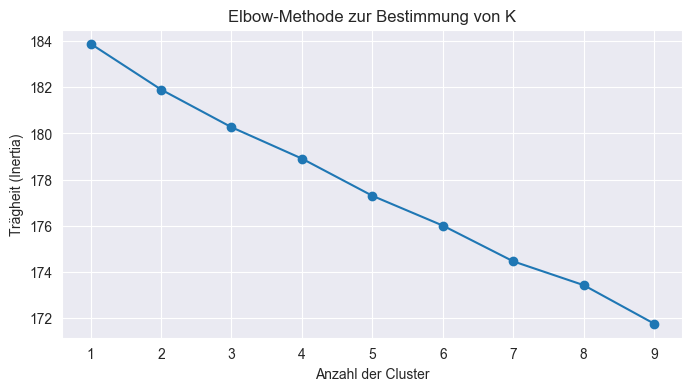

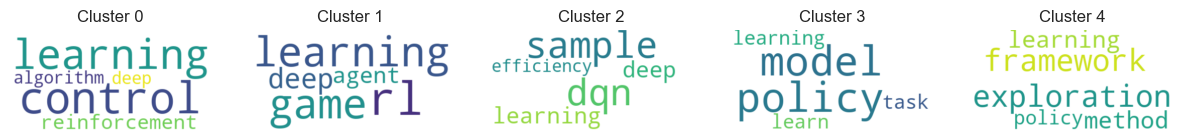

===================================================   2019   ===================================================


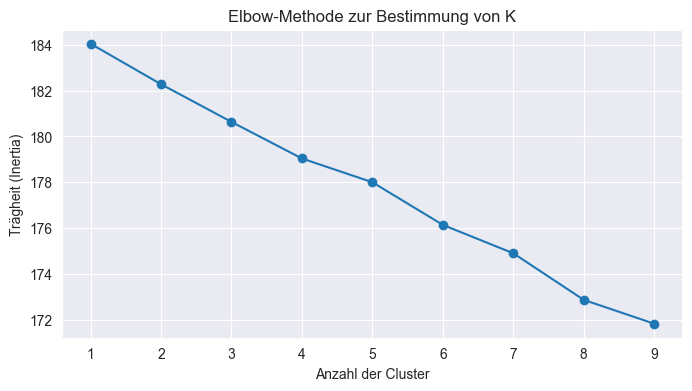

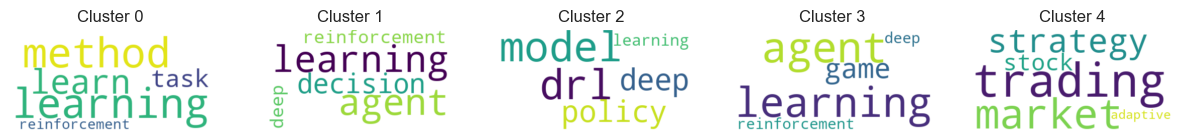

===================================================   2020   ===================================================


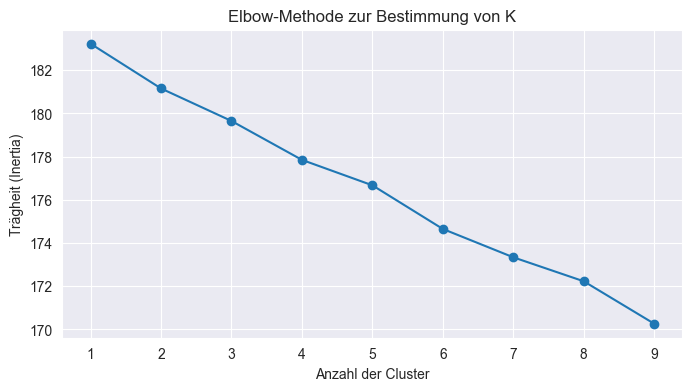

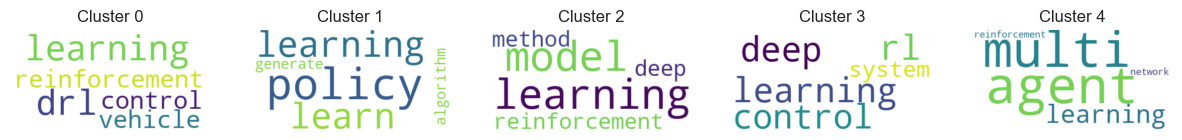

===================================================   2021   ===================================================


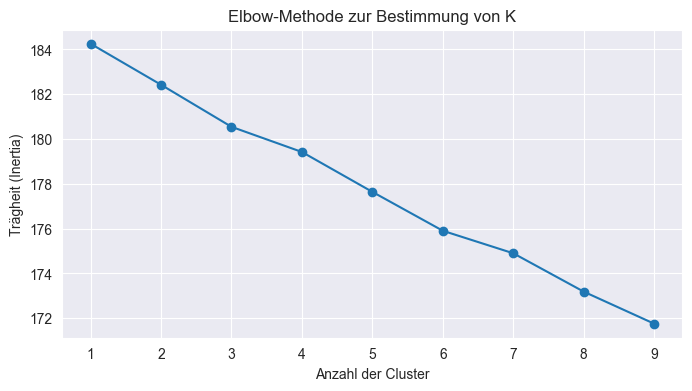

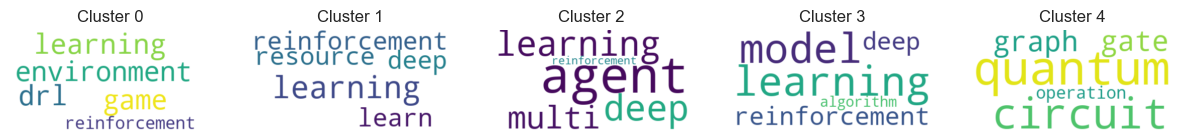

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from extraction import extract_data_from_arxiv
from preparation import prepare_data
from filtering import filter_abstract
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud

# Find best K with elbow method to cluster
def find_optimal_k(x, max_k=10):
    distortions = []
    for k in range(1, max_k):
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(x)
        distortions.append(km.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_k), distortions, marker='o')
    plt.xlabel("Anzahl der Cluster")
    plt.ylabel("Trägheit (Inertia)")
    plt.title("Elbow-Methode zur Bestimmung von K")
    plt.show()

    # Get keywords from the clusters
def get_cluster_keywords(x, clusters, features, top_n=5):
    cluster_keywords = {}
    for cluster in range(num_clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        words = np.array(x[cluster_indices].sum(axis=0)).flatten()
        most_significant_words = [features[i] for i in words.argsort()[-top_n:][::-1]]
        cluster_keywords[cluster] = ", ".join(most_significant_words)
    return cluster_keywords

# Define the years to analyze
years = range(2018, 2022)

# Extract and prepare data and filter the abstract for stopwords
df = extract_data_from_arxiv()
df = prepare_data(df, years, show_histograms=False, explode_authors=False)
df = filter_abstract(df)

for year in years:

    # Filter for the specific year
    year_filtered_df = df[df["PublishedDate"].dt.year == year].copy()

    # Vectorize the abstract
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(year_filtered_df["Abstract"])

    # Add delimiter to separate the years in the output
    print(f"===================================================   {year}   ===================================================")

    # Apply Kmeans algorithm
    find_optimal_k(X, max_k=10)

    # Use elbow method to cluster
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    year_filtered_df["Cluster"] = kmeans.fit_predict(X)

    # Get names of clusters
    feature_names = vectorizer.get_feature_names_out()
    cluster_names = get_cluster_keywords(X.toarray(), year_filtered_df["Cluster"].values, feature_names)

    # Show results with cluster names
    year_filtered_df["Cluster Name"] = year_filtered_df["Cluster"].map(cluster_names)

    # Print wordcloud for the cluster names
    fig, axes = plt.subplots(1, len(cluster_names), figsize=(15, 5))
    for i, (cluster_id, keywords) in enumerate(cluster_names.items()):
        wordcloud = WordCloud(background_color="white").generate(keywords)
        axes[i].imshow(wordcloud, interpolation="bilinear")
        axes[i].set_title(f"Cluster {cluster_id}")
        axes[i].axis("off")

    plt.show()